In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'dogs-vs-cats:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F84954%2F196452%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240422%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240422T100821Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4defc400e825de7cf90d245e6d39715a7a7c7cafcd894e7e70c1771e64ac7a85d14b91bb46662f8049b185305a73516f5cd8eb1bfbd96d9a49d75547fa55dee292982b2abb79fb9963034a9ee298f790b1cd233d1b006a6a29073a56f5ff87fe34bad10f37785937cc5c865de8283feb023a111d6181208f09725f0c658e12314f063d39be73f130c97b3d29b29b2870e5b1c7cc713ca0d10eea5f5304ea6c356df0234e41378d9cad05b65d5bd8dc66d26f5fce7e69ef6d374f0f8e7fbcfa1498ba33fda9ff6a18206bf7c36ed3832f7273f5d76e3347e75d10becfdc7efa56539e1f0d454d723250785ad44795f53a70377b3461206094369fc21020547064'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1142891694 bytes downloaded
Downloaded and uncompressed: dogs-vs-cats
Data source import complete.


In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
import matplotlib.pyplot as plt

In [3]:
#Generator
train_ds=keras.utils.image_dataset_from_directory(
directory='/kaggle/input/dogs-vs-cats/train',
labels='inferred',
label_mode='int',
batch_size=32,
image_size=(256,256)
)

validation_ds=keras.utils.image_dataset_from_directory(
directory='/kaggle/input/dogs-vs-cats/test',
labels='inferred',
label_mode='int',
batch_size=32,
image_size=(256,256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [4]:
# Normalize
def process(image,label):
  image = tf.cast(image/255.,tf.float32)
  return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [5]:
# create CNN Model

model =Sequential()

model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
625/625 [==============================] - 62s 86ms/step - loss: 0.6283 - accuracy: 0.6417 - val_loss: 0.5337 - val_accuracy: 0.7348
Epoch 2/10
625/625 [==============================] - 55s 87ms/step - loss: 0.4926 - accuracy: 0.7582 - val_loss: 0.5486 - val_accuracy: 0.7286
Epoch 3/10
625/625 [==============================] - 58s 91ms/step - loss: 0.3721 - accuracy: 0.8316 - val_loss: 0.5102 - val_accuracy: 0.7860
Epoch 4/10
625/625 [==============================] - 62s 99ms/step - loss: 0.2438 - accuracy: 0.8976 - val_loss: 0.6458 - val_accuracy: 0.7944
Epoch 5/10
625/625 [==============================] - 57s 91ms/step - loss: 0.1369 - accuracy: 0.9448 - val_loss: 0.8537 - val_accuracy: 0.7818
Epoch 6/10
625/625 [==============================] - 54s 85ms/step - loss: 0.0894 - accuracy: 0.9674 - val_loss: 1.0348 - val_accuracy: 0.7886
Epoch 7/10
625/625 [==============================] - 52s 82ms/step - loss: 0.0655 - accuracy: 0.9784 - val_loss: 1.1300 - val_accuracy:

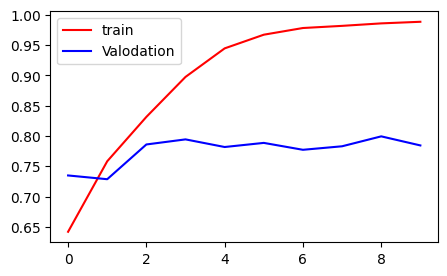

In [11]:
plt.figure(figsize=(5,3))
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='Valodation')
plt.legend()
plt.show()

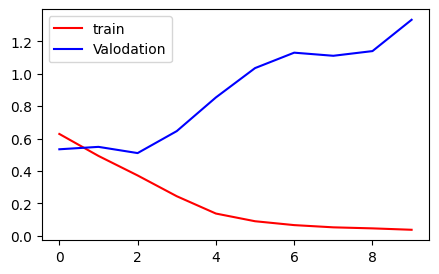

In [13]:
plt.figure(figsize=(5,3))
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='Valodation')
plt.legend()
plt.show()

# Ways to reduce overfitting
* Add more data
* Data Augmentation
* L1/L2 Regularization
* Dropout
* Batch Norm
* Reduce Complxity

# Dropout

In [14]:
# create CNN Model

model =Sequential()

model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                      

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
history = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
625/625 [==============================] - 83s 133ms/step - loss: 0.3991 - accuracy: 0.8191 - val_loss: 0.5436 - val_accuracy: 0.7196
Epoch 2/10
625/625 [==============================] - 64s 102ms/step - loss: 0.3231 - accuracy: 0.8598 - val_loss: 0.5290 - val_accuracy: 0.7580
Epoch 3/10
625/625 [==============================] - 65s 104ms/step - loss: 0.2482 - accuracy: 0.8945 - val_loss: 0.6324 - val_accuracy: 0.7602
Epoch 4/10
625/625 [==============================] - 67s 106ms/step - loss: 0.1732 - accuracy: 0.9292 - val_loss: 0.8846 - val_accuracy: 0.7188
Epoch 5/10
625/625 [==============================] - 67s 107ms/step - loss: 0.1253 - accuracy: 0.9539 - val_loss: 0.5496 - val_accuracy: 0.8194
Epoch 6/10
625/625 [==============================] - 67s 107ms/step - loss: 0.0820 - accuracy: 0.9696 - val_loss: 0.6196 - val_accuracy: 0.7980
Epoch 7/10
625/625 [==============================] - 67s 107ms/step - loss: 0.0725 - accuracy: 0.9753 - val_loss: 0.9138 - val_ac

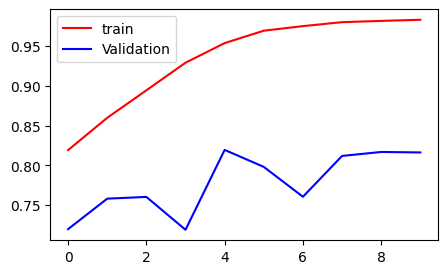

In [20]:
plt.figure(figsize=(5,3))
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation')
plt.legend()
plt.show()

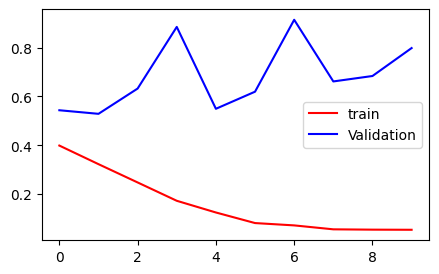

In [21]:
plt.figure(figsize=(5,3))
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='Validation')
plt.legend()
plt.show()

In [26]:
# create CNN Model

model2 =Sequential()

model2.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256,256,3)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model2.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model2.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model2.add(Flatten())

model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))

In [27]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_6 (Bat  (None, 254, 254, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_7 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                      

In [28]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
history = model2.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
625/625 [==============================] - 74s 114ms/step - loss: 1.9231 - accuracy: 0.5524 - val_loss: 0.6314 - val_accuracy: 0.6040
Epoch 2/10
625/625 [==============================] - 83s 131ms/step - loss: 0.6269 - accuracy: 0.6353 - val_loss: 0.5600 - val_accuracy: 0.7076
Epoch 3/10
625/625 [==============================] - 67s 107ms/step - loss: 0.5645 - accuracy: 0.6962 - val_loss: 0.6023 - val_accuracy: 0.6834
Epoch 4/10
625/625 [==============================] - 72s 114ms/step - loss: 0.4997 - accuracy: 0.7450 - val_loss: 0.4665 - val_accuracy: 0.7768
Epoch 5/10
625/625 [==============================] - 80s 128ms/step - loss: 0.4534 - accuracy: 0.7703 - val_loss: 0.4352 - val_accuracy: 0.7954
Epoch 6/10
625/625 [==============================] - 75s 120ms/step - loss: 0.4158 - accuracy: 0.7954 - val_loss: 0.4924 - val_accuracy: 0.7748
Epoch 7/10
625/625 [==============================] - 67s 107ms/step - loss: 0.3696 - accuracy: 0.8175 - val_loss: 0.4306 - val_ac

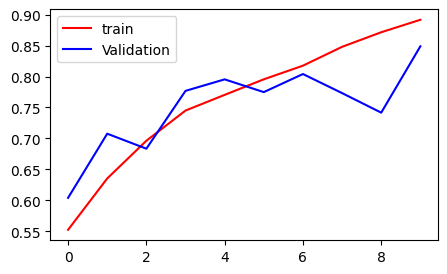

In [30]:
plt.figure(figsize=(5,3))
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation')
plt.legend()
plt.show()

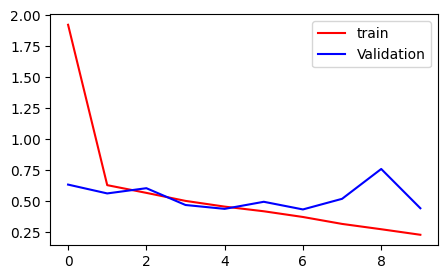

In [31]:
plt.figure(figsize=(5,3))
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='Validation')
plt.legend()
plt.show()

# Dropout 0.3

In [32]:
# create CNN Model

model3 =Sequential()

model3.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256,256,3)))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model3.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model3.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model3.add(Flatten())

model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(1, activation='sigmoid'))

In [33]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_9 (Bat  (None, 254, 254, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_10 (Ba  (None, 125, 125, 64)      256       
 tchNormalization)                                               
                                                      

In [34]:
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
history = model3.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
625/625 [==============================] - 68s 104ms/step - loss: 1.9670 - accuracy: 0.5470 - val_loss: 0.6599 - val_accuracy: 0.5980
Epoch 2/10
625/625 [==============================] - 67s 107ms/step - loss: 0.6544 - accuracy: 0.6220 - val_loss: 0.6100 - val_accuracy: 0.6828
Epoch 3/10
625/625 [==============================] - 67s 107ms/step - loss: 0.5778 - accuracy: 0.7032 - val_loss: 0.5743 - val_accuracy: 0.7224
Epoch 4/10
625/625 [==============================] - 67s 107ms/step - loss: 0.5260 - accuracy: 0.7473 - val_loss: 0.4740 - val_accuracy: 0.7790
Epoch 5/10
625/625 [==============================] - 68s 107ms/step - loss: 0.4591 - accuracy: 0.7878 - val_loss: 0.4540 - val_accuracy: 0.8066
Epoch 6/10
625/625 [==============================] - 64s 102ms/step - loss: 0.4123 - accuracy: 0.8173 - val_loss: 0.4520 - val_accuracy: 0.7872
Epoch 7/10
625/625 [==============================] - 64s 101ms/step - loss: 0.3641 - accuracy: 0.8421 - val_loss: 1.2864 - val_ac

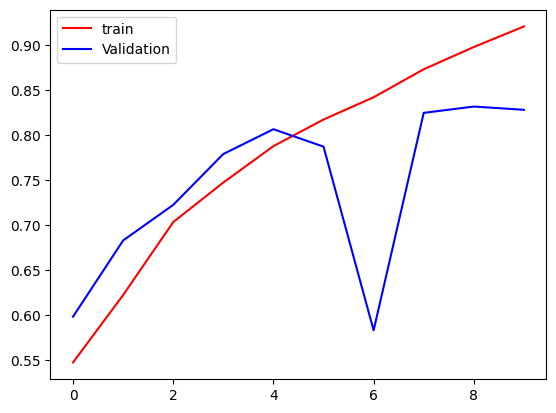

In [36]:
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation')
plt.legend()
plt.show()

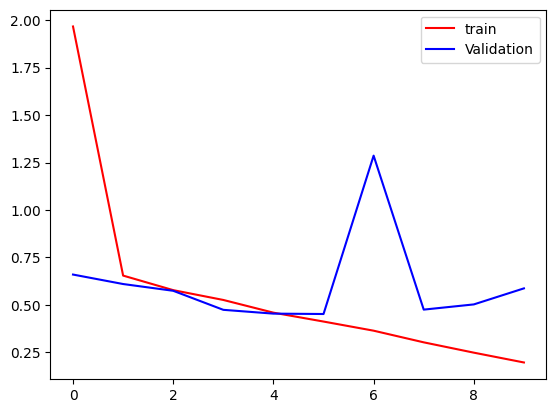

In [37]:
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='Validation')
plt.legend()
plt.show()

L2 Regularization

In [38]:
# create CNN Model

model4 =Sequential()

model4.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256,256,3)))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model4.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model4.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model4.add(Flatten())

model4.add(Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model4.add(Dropout(0.2))
model4.add(Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model4.add(Dropout(0.2))
model4.add(Dense(1, activation='sigmoid'))

In [39]:
model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_12 (Ba  (None, 254, 254, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_13 (Ba  (None, 125, 125, 64)      256       
 tchNormalization)                                               
                                                      

In [40]:
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
history = model4.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
625/625 [==============================] - 68s 104ms/step - loss: 1.9983 - accuracy: 0.5756 - val_loss: 1.2062 - val_accuracy: 0.6356
Epoch 2/10
625/625 [==============================] - 69s 110ms/step - loss: 0.9623 - accuracy: 0.6873 - val_loss: 0.8414 - val_accuracy: 0.6870
Epoch 3/10
625/625 [==============================] - 65s 104ms/step - loss: 0.9071 - accuracy: 0.7348 - val_loss: 1.2790 - val_accuracy: 0.5934
Epoch 4/10
625/625 [==============================] - 68s 108ms/step - loss: 0.7387 - accuracy: 0.7829 - val_loss: 0.6653 - val_accuracy: 0.7920
Epoch 5/10
625/625 [==============================] - 65s 104ms/step - loss: 0.6646 - accuracy: 0.8082 - val_loss: 0.9169 - val_accuracy: 0.7332
Epoch 6/10
625/625 [==============================] - 67s 107ms/step - loss: 0.7422 - accuracy: 0.8274 - val_loss: 1.2217 - val_accuracy: 0.6992
Epoch 7/10
625/625 [==============================] - 64s 102ms/step - loss: 0.8215 - accuracy: 0.8468 - val_loss: 0.9324 - val_ac

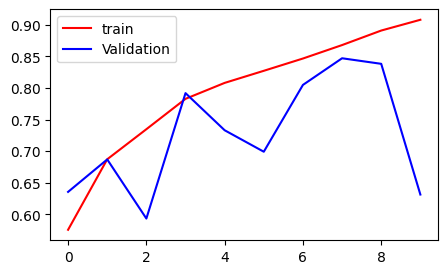

In [42]:
plt.figure(figsize=(5,3))
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation')
plt.legend()
plt.show()

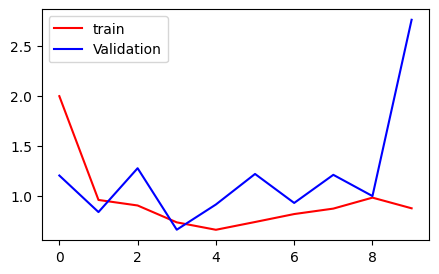

In [43]:
plt.figure(figsize=(5,3))
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='Validation')
plt.legend()
plt.show()

In [44]:
# create CNN Model

model5 =Sequential()

model5.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256,256,3)))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model5.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model5.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2), padding="valid"))

model5.add(Flatten())

model5.add(Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model5.add(Dropout(0.3))
model5.add(Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model5.add(Dropout(0.3))
model5.add(Dense(1, activation='sigmoid'))

In [45]:
model5.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_15 (Ba  (None, 254, 254, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_16 (Ba  (None, 125, 125, 64)      256       
 tchNormalization)                                               
                                                      

In [46]:
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
history = model5.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
625/625 [==============================] - 85s 105ms/step - loss: 3.3043 - accuracy: 0.5523 - val_loss: 1.5906 - val_accuracy: 0.6016
Epoch 2/10
625/625 [==============================] - 68s 108ms/step - loss: 1.2853 - accuracy: 0.6089 - val_loss: 0.9758 - val_accuracy: 0.7074
Epoch 3/10
625/625 [==============================] - 68s 109ms/step - loss: 0.9621 - accuracy: 0.6766 - val_loss: 0.9557 - val_accuracy: 0.7024
Epoch 4/10
625/625 [==============================] - 67s 106ms/step - loss: 0.8181 - accuracy: 0.7319 - val_loss: 0.8101 - val_accuracy: 0.7240
Epoch 5/10
625/625 [==============================] - 68s 109ms/step - loss: 0.7967 - accuracy: 0.7653 - val_loss: 0.8147 - val_accuracy: 0.7770
Epoch 6/10
625/625 [==============================] - 65s 103ms/step - loss: 0.8013 - accuracy: 0.7919 - val_loss: 0.8388 - val_accuracy: 0.7748
Epoch 7/10
625/625 [==============================] - 65s 104ms/step - loss: 0.8684 - accuracy: 0.8183 - val_loss: 1.0618 - val_ac

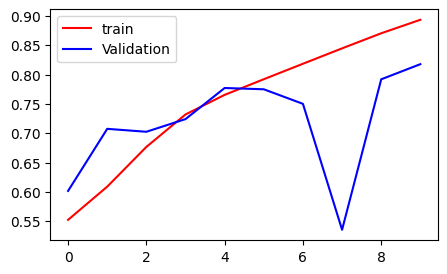

In [48]:
plt.figure(figsize=(5,3))
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation')
plt.legend()
plt.show()

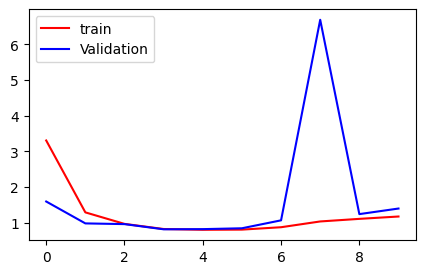

In [49]:
plt.figure(figsize=(5,3))
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='Validation')
plt.legend()
plt.show()

* test

In [50]:
import cv2

In [134]:
test_img = cv2.imread('/kaggle/input/dogs-vs-cats/train/cats/cat.1004.jpg')

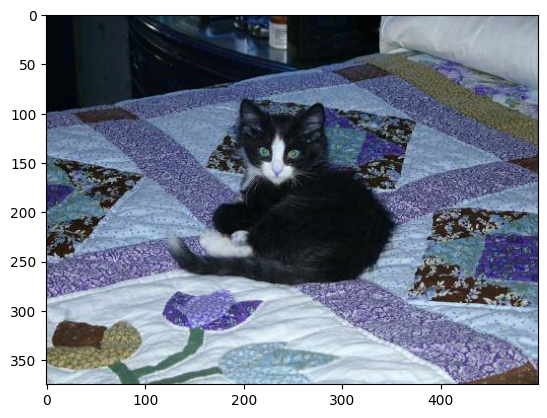

In [135]:
plt.imshow(test_img)

In [136]:
test_img.shape

(375, 499, 3)

In [137]:
test_img = cv2.resize(test_img,(256,256))

In [138]:
test_img.shape

(256, 256, 3)

In [139]:
test_input = test_img.reshape(1,256,256,3)

In [140]:
model.predict(test_input)

1/1 [==============================] - 0s 35ms/step


array([[3.405397e-21]], dtype=float32)

In [141]:
test_img = cv2.imread('/kaggle/input/dogs-vs-cats/train/cats/cat.10044.jpg')
test_img = cv2.resize(test_img,(256,256))
test_input = test_img.reshape(1,256,256,3)
model.predict(test_input)

1/1 [==============================] - 0s 28ms/step


array([[5.768375e-14]], dtype=float32)

In [144]:
test_img = cv2.imread('/kaggle/input/dogs-vs-cats/test/cats/cat.10000.jpg')
test_img = cv2.resize(test_img,(256,256))
test_input = test_img.reshape(1,256,256,3)
model.predict(test_input)

1/1 [==============================] - 0s 19ms/step


array([[9.8583533e-29]], dtype=float32)

In [127]:
test_img = cv2.imread('/kaggle/input/dogs-vs-cats/dogs_vs_cats/test/dogs/dog.10059.jpg')

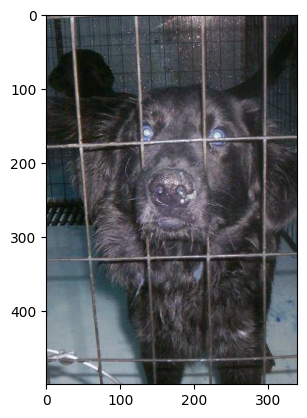

In [128]:
plt.imshow(test_img)

In [129]:
test_img.shape

(500, 340, 3)

In [130]:
test_img = cv2.resize(test_img,(256,256))

In [131]:
test_img.shape

(256, 256, 3)

In [132]:
test_input = test_img.reshape(1,256,256,3)

In [133]:
model2.predict(test_input)[0]

1/1 [==============================] - 0s 18ms/step


array([1.], dtype=float32)